In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
import time
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit



from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [2]:
data_h_lhs=pd.read_csv('h_LHS.csv',index_col=False)
# data_h_T_lhs=pd.read_csv('h_T_LHS.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS.csv',index_col=False)

data_h_uniform_5000=pd.read_csv('h_uniform_5000.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000.csv',index_col=False)


##testing lambda
data_lambda_uniform_5000=pd.read_csv('lambda_uniform_5000.csv',index_col=False)

In [3]:
### Reading values only
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values

# Input without scaling
h_in_notscaled=torch.tensor(h_in).float()
T_in_notscaled=torch.tensor(T_in).float()
Lambda_in_notscaled=torch.tensor(Lambda_in).float()



Lambda_in_test_5000=data_lambda_uniform_5000.values

# Scaling the input and outputs
min_max_scaler_h =MinMaxScaler()
min_max_scaler_T =MinMaxScaler()
min_max_scaler_lambda =MinMaxScaler()

h_scale_in= min_max_scaler_h.fit_transform(h_in)
T_scale_in= min_max_scaler_T.fit_transform(T_in)
Lambda_scale_in= min_max_scaler_lambda.fit_transform(Lambda_in)

## Converting into tensor for nn
h_tensor=torch.Tensor(h_scale_in)[0:3000]
T_tensor=torch.Tensor(T_scale_in)[0:3000]
Lambda_tensor=torch.Tensor(Lambda_scale_in)[0:3000]


h_tensor_2000=torch.Tensor(h_scale_in)[3000:5000]
T_tensor_2000=torch.Tensor(T_scale_in)[3000:5000]
Lambda_tensor_2000=torch.Tensor(Lambda_scale_in)[3000:5000]

##test Data preparation
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values
lambda_test_in_5000=data_lambda_uniform_5000.values

min_max_scaler_h_5000 =MinMaxScaler()
min_max_scaler_T_5000 =MinMaxScaler()
min_max_scaler_lambda_5000=MinMaxScaler()

scale_h_test_in_5000=min_max_scaler_h_5000.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler_T_5000.fit_transform(T_test_in_5000)
scale_Lambda_test_in_5000=min_max_scaler_lambda_5000.fit_transform(lambda_test_in_5000)


h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)
Lambda_tensor_5000=torch.Tensor(scale_Lambda_test_in_5000)

# test data
h_in_notscaled_5000=torch.tensor(h_test_in_5000).float()
T_in_notscaled_5000=torch.tensor(T_test_in_5000).float()
lambda_in_notscaled_5000=torch.tensor(lambda_test_in_5000).float()

# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor

In [4]:
min_max_scaler_T_5000.inverse_transform(T_tensor_5000)

array([[        0.],
       [        0.],
       [        0.],
       ...,
       [-47000000.],
       [-47000000.],
       [-47000000.]])

In [23]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        # self.fc4 = nn.Linear(2, 32)
        # self.fc5 = nn.Linear(32, 64)
        # self.fc6 = nn.Linear(64, 1)

    def forward(self, h,T):
        
        # tuple_in1 = (h_tensor, T_tensor)
        # in_1 = torch.cat(tuple_in1,-1)
        # in_1 = torch.stack(h,T)
        in_1=torch.concat((h,T),1)
        x1 = torch.relu(self.fc1(in_1))
        x2 = torch.relu(self.fc2(x1))
        output_1 = self.fc3(x2)

        # tuple_in2 = (output_1, h_tensor)
        # in_2 = torch.cat(tuple_in2,-1)
        # # in_2 = torch.stack(output_1,h)
        # # in_2=torch.concat(output_1,h)
        # x3 = torch.relu(self.fc4(in_2))
        # x4 = torch.relu(self.fc5(x3))
        # output_2 = self.fc6(x4)
        return output_1

# Create a model instance from the network
model2 = Net()
print(model2)
model2.state_dict()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


OrderedDict([('fc1.weight',
              tensor([[ 0.1672,  0.0156],
                      [ 0.4055, -0.1546],
                      [-0.4162,  0.2700],
                      [ 0.1887,  0.2692],
                      [-0.0785, -0.0938],
                      [-0.0562,  0.1865],
                      [-0.5426, -0.6591],
                      [ 0.2646, -0.3871],
                      [-0.0595,  0.1960],
                      [ 0.0992,  0.4558],
                      [ 0.0927,  0.1751],
                      [-0.0633,  0.1044],
                      [ 0.2593,  0.4824],
                      [-0.6700, -0.2946],
                      [-0.6345, -0.2819],
                      [ 0.4310, -0.6700],
                      [-0.6336,  0.4094],
                      [-0.4176,  0.5168],
                      [ 0.2203,  0.1775],
                      [ 0.5617, -0.6550],
                      [ 0.5178,  0.2293],
                      [-0.4738,  0.1720],
                      [-0.1971, -0.2838],
      

In [24]:
loss_criteria=nn.MSELoss()
# alpha=1
# beta=10**(-14)
def train_iter(model,h,T,lam,optimizer):
  # for i in range(len(h)):
  model.train()
  
  # for i in range(len(h)):
  # optimizer.zero_grad()
  out1=model(h,T)
  loss1=loss_criteria(out1,lam)
  loss=loss1
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss,out1



In [25]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 5000
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out= train_iter(model2,h_tensor,Lambda_tensor,T_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.5098683
Epoch: 2
0.49045205
Epoch: 3
0.47142637
Epoch: 4
0.4527043
Epoch: 5
0.43431944
Epoch: 6
0.41638267
Epoch: 7
0.399038
Epoch: 8
0.38241082
Epoch: 9
0.36670154
Epoch: 10
0.35205904
Epoch: 11
0.33867374
Epoch: 12
0.32677594
Epoch: 13
0.31643978
Epoch: 14
0.30770013
Epoch: 15
0.30056953
Epoch: 16
0.2950475
Epoch: 17
0.29109776
Epoch: 18
0.28861094
Epoch: 19
0.28741524
Epoch: 20
0.2872866
Epoch: 21
0.28794807
Epoch: 22
0.28911892
Epoch: 23
0.2905398
Epoch: 24
0.29198536
Epoch: 25
0.29326978
Epoch: 26
0.29425722
Epoch: 27
0.29486716
Epoch: 28
0.29506645
Epoch: 29
0.29485515
Epoch: 30
0.29428887
Epoch: 31
0.2934204
Epoch: 32
0.29233196
Epoch: 33
0.29111525
Epoch: 34
0.2898565
Epoch: 35
0.28863105
Epoch: 36
0.28749698
Epoch: 37
0.28649682
Epoch: 38
0.28565508
Epoch: 39
0.28498042
Epoch: 40
0.28446925
Epoch: 41
0.28410614
Epoch: 42
0.28386807
Epoch: 43
0.2837276
Epoch: 44
0.28365567
Epoch: 45
0.28362405
Epoch: 46
0.28360465
Epoch: 47
0.28357714
Epoch: 48
0.2835282
Epoch: 49
0.

<function matplotlib.pyplot.show(close=None, block=None)>

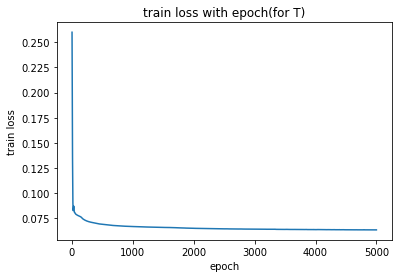

In [26]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch(for T)')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [33]:
prediction_LHS_T_train_3000=model2(h_tensor,Lambda_tensor)
prediction_LHS_T_train_3000.shape

torch.Size([3000, 1])

In [34]:
prediction_LHS_T_train_2000=model2(h_tensor_2000,Lambda_tensor_2000)
prediction_LHS_T_train_2000.shape

torch.Size([2000, 1])

In [35]:
prediction_T_train_5000=model2(h_tensor_5000,Lambda_tensor_5000)
prediction_T_train_5000.shape

torch.Size([5000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

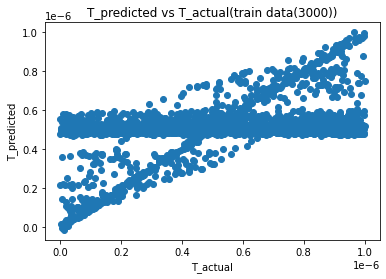

In [37]:
plt.scatter((T_tensor)/10**6,(prediction_LHS_T_train_3000.detach().numpy())/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(train data(3000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

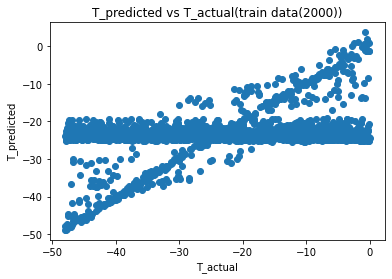

In [38]:
plt.scatter(min_max_scaler_T.inverse_transform(T_tensor_2000)/10**6,min_max_scaler_T.inverse_transform(prediction_LHS_T_train_2000.detach().numpy())/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(train data(2000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

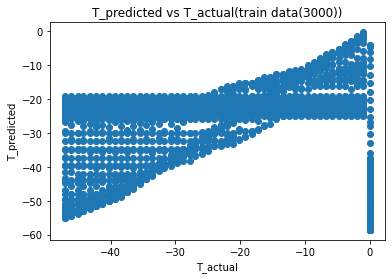

In [39]:
plt.scatter(min_max_scaler_T_5000.inverse_transform(T_tensor_5000)/10**6,min_max_scaler_T_5000.inverse_transform(prediction_T_train_5000.detach().numpy())/10**6)
plt.xlabel("T_actual")
plt.ylabel("T_predicted")
plt.title('T_predicted vs T_actual(train data(3000))')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

In [49]:
min_max_scaler_T_5000.inverse_transform(T_tensor_5000),min_max_scaler_T_5000.inverse_transform(prediction_T_train_5000.detach().numpy())

(array([[        0.],
        [        0.],
        [        0.],
        ...,
        [-47000000.],
        [-47000000.],
        [-47000000.]]),
 array([[-30336558.],
        [ -4572825.],
        [ -3564998.],
        ...,
        [-22714524.],
        [-22936278.],
        [-23158016.]], dtype=float32))